Assignment 3 - Diachronic analysis of movie dialogues
===

*Due: January 1 2023*

In this assignment you will analyze how the expression of Hope in movie dialogues changed with time.

## Imports

In [1]:
import os
from nltk.corpus import wordnet as wn
import pandas as pd
import ipywidgets as widgets
import itertools
import nltk
import regex as re
import contractions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models.word2vec import Word2Vec
import ast
from glob import glob
import collections
from scipy import stats
import numpy as np


lemma = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
layout = widgets.Layout(width="auto")
lang = "eng"
data_path = "data/dialogs_preprocessed2/"

## Functions

### Functions for text preprocessing

In [2]:
def clean_url(input):
    output = re.sub(r"http\S+", "", input)
    return output


def fix_contraction(input):
    output = contractions.fix(input)
    return output


def clean_non_alphanumeric(input):
    output = re.sub(r"[^a-zA-Z0-9]", " ", input)
    return output


def clean_tokenization(input):
    output = nltk.word_tokenize(input)
    return output


def clean_stopwords(input):
    output = [item for item in input if item not in stop_words]
    return output


def numbers_to_words(input):
    output = []
    for item in input:
        if item.isnumeric() == True:
            output += [p.number_to_words(item)]
        else:
            output += [item]
    return output


def clean_lowercase(input):
    output = str(input).lower()
    return output


def clean_lemmatization(input):
    output = [lemma.lemmatize(word=w, pos="v") for w in input]
    return output


def clean_length(input):
    output = [word for word in input if len(word) > 2]
    return output


def convert_to_string(input):
    output = " ".join(input)
    return output


def preprocessing(text, remove_stopwords=True):
    """
    Preprocessing pipeline.
    """
    text = clean_url(text)
    text = fix_contraction(text)
    text = clean_non_alphanumeric(text)
    text = clean_lowercase(text)
    text = clean_tokenization(text)
    text = numbers_to_words(text)
    if remove_stopwords:
        text = clean_stopwords(text)
    text = clean_lemmatization(text)
    text = clean_length(text)
    text = convert_to_string(text)
    return text

### Functions for wordnet

In [3]:
def generate_word_list(seed_word, language):
    """
    Takes in a single seed word and returns
    a word list, the length and a list of synsets
    """

    ## we create an empty list to store the final word list
    list_of_lemmas = []
    list_of_meanings = []

    ## a function to add a word to a list
    add_to_list = lambda list1, item1: list1.append(item1)

    ## a function to return the hyponyms of a synset
    hypos = lambda s: s.hyponyms()

    ## wn.synset obtains the list of synonyms and meanings for that word, in different syntactic categories
    meanings = wn.synsets(seed_word, pos=wn.NOUN + wn.VERB + wn.ADJ)

    ## loop over set of meanings in synset
    for meaning in meanings:

        ## add synset, definition, and a list of all associated lemmas into the list_of_meanings
        list_of_meanings += [
            [
                meaning,
                meaning.definition(),
                [lemma.name() for lemma in meaning.lemmas(language)],
            ]
        ]

        ## append all synonyms (lemmas()) of that meaning to the list_of_lemmas
        [
            add_to_list(list_of_lemmas, lemma.name())
            for lemma in meaning.lemmas(language)
        ]

        ## loop over the list of all possible hyponyms
        for hyponym in meaning.closure(hypos):

            ## add synsets, definition, and a list of all associated lemmas into the list_of_meanings
            list_of_meanings += [
                [
                    hyponym,
                    hyponym.definition(),
                    [lemma.name() for lemma in hyponym.lemmas(language)],
                ]
            ]

            ## append all synonyms (lemmas()) of that hyponym to the list_of_lemmas
            [
                add_to_list(list_of_lemmas, lemma.name())
                for lemma in hyponym.lemmas(language)
            ]

    ##eliminate list duplications by applying the set transformation
    set_of_lemmas = [*set(list_of_lemmas)]

    ## sort alphabetically
    set_of_lemmas.sort()

    ##length
    length = len(set_of_lemmas)

    return (set_of_lemmas, length, list_of_meanings)


def prune_list(w, syn_list):
    """
    Takes in a container checkbox widget,
    a list with synsets and returns
    a filtered word list.
    """

    filtered_meanings = list(
        itertools.compress(syn_list, [widget.value for widget in w.children])
    )

    filtered_list = [word for lemmas in filtered_meanings for word in lemmas[2]]

    filtered_list = sorted([*set(filtered_list)])

    return filtered_list


def expand_meanings(seed_words, language):
    """
    Takes in a list of seed words and returns all synsets.
    """

    list_meanings = []

    for sw in seed_words:
        _, _, meanings = generate_word_list(sw, language)
        list_meanings += meanings

    list_meanings.sort()

    # groupby also eliminates duplications
    list(list_meanings for list_meanings, _ in itertools.groupby(list_meanings))

    return list_meanings

### Functions for vec2word

In [4]:
def create_word2vec_input(root_folder):
    """

    Function to select .txt files and store them as a list of paragraphs,
    each a list of words, to use as input to the function WordVec.

    This function was originally named "literary_words_list".

    Parameters
    ----------
    root_folder : a file path where .txt files are located
    e.g. '~/home/user/text_analyses'

    Returns
    -------
    A list of the paragraphs, each paragraph a list of words

    """

    word2vec_input = []

    for path, subdirs, files in os.walk(root_folder):
        for file in files:
            if ".txt" in file and "model" not in file:
                # print(file)
                name = os.path.join(path, file)
                file_text = open(name, encoding="utf-8").read()
                text_list_paragraphs = file_text.split("\n")

                for paragraph in text_list_paragraphs:
                    paragraph = paragraph.replace("\r", "")
                    list_of_sentences = nltk.sent_tokenize(paragraph)

                    for sentence in list_of_sentences:
                        word2vec_input += [preprocessing(sentence)]

    # remove empty strings and split sentences into lists
    word2vec_input = [s.split() for s in word2vec_input if s != ""]

    return word2vec_input


def get_word2vec_list(word_list, model):
    """
    Function to use word2vec to inquiry about the 10 most similar semantically
    words to each seed word in word_list. Uses a pre-trained model to get the
    most similar words within the text.

    """

    list_of_word2vec_lists = []
    for word in word_list:
        try:

            ##
            list_vects = model.wv.most_similar([word], topn=10)

            new_list = []
            new_list += [word]
            for item in list_vects:
                word1 = item[0]
                new_list += [word1]

            # print(new_list)
            # print('\n')
            list_of_word2vec_lists += [new_list]

        except KeyError:
            continue

    return list_of_word2vec_lists

### Functions for word frequency

In [5]:
def compute_frequencies(list_string, list_of_categories):
    """
    Function to calculate word frequencies.

    """

    global apply_counter1

    tokenized_text = ast.literal_eval(list_string)
    word_counter = collections.Counter(tokenized_text)
    total_words = len(tokenized_text)

    list_of_category_frequencies = []
    for category in list_of_categories:
        category_count = 0.0

        for word in category:
            category_count += int(word_counter[word])

        if total_words != 0 and category_count > 0:
            category_frequency = category_count / total_words
        else:
            category_frequency = float("nan")
        list_of_category_frequencies += [category_frequency]

    apply_counter1 += 1

    return list_of_category_frequencies

## 0. Expression of interest: Hope

In [6]:
seed_word = "hope"

## 1. Control measure: Rage

Find control measure to contrast with "Hope"

In [7]:
ctrl_seed_word = "rage"

## 2. Initial bags of seeds

Find psychometric tools or equivalent to generate initial bags of seeds, for both Hope and the control condition

In [8]:
seed_list = generate_word_list(seed_word, lang)
print(f"Length of lemma list is {seed_list[1]}")

Length of lemma list is 16


In [9]:
ctrl_seed_list = generate_word_list(ctrl_seed_word, lang)
print(f"Length of lemma list is {ctrl_seed_list[1]}")

Length of lemma list is 29


## 3. Expand bag of seeds and get synonyms and hyponyms

Use WordNet tools to expand your bag of seeds and get synonyms and hyponyms, and start excluding words with unrelated meanings using the filters available.

### Hope

In [10]:
selection_widget = widgets.VBox(
    [
        widgets.Checkbox(
            value=True,
            description=str(item),
            disabled=False,
            indent=False,
            layout=layout,
        )
        for item in seed_list[2]
    ]
)

selection_widget

In [11]:
seed_words = prune_list(selection_widget, seed_list[2])

print(seed_words)

['desire', 'encouragement', 'go_for', 'great_white_hope', 'hope', 'hopefulness', 'optimism', 'promise', 'rainbow', 'sanguineness', 'sanguinity', 'trust', 'white_hope']


#### Extend

In [12]:
synsets = expand_meanings(seed_words, lang)
len(synsets)

300

In [13]:
synsets[:3]

[[Synset('abetment.n.01'),
  'the verbal act of urging on',
  ['abetment', 'abettal', 'instigation']],
 [Synset('accept.v.03'),
  'give an affirmative reply to; respond favorably to',
  ['accept', 'consent', 'go_for']],
 [Synset('accept.v.07'),
  'tolerate or accommodate oneself to',
  ['accept', 'live_with', 'swallow']]]

### Rage

In [14]:
ctrl_selection_widget = widgets.VBox(
    [
        widgets.Checkbox(
            value=True,
            description=str(item),
            disabled=False,
            indent=False,
            layout=layout,
        )
        for item in ctrl_seed_list[2]
    ]
)

ctrl_selection_widget

In [15]:
ctrl_seed_words = prune_list(ctrl_selection_widget, ctrl_seed_list[2])

print(ctrl_seed_words)

['blow_a_fuse', "blow_one's_stack", 'blow_up', 'combust', 'craze', 'cult', 'fad', "flip_one's_lid", "flip_one's_wig", 'fly_off_the_handle', 'foam_at_the_mouth', 'froth_at_the_mouth', 'furor', 'furore', 'fury', 'go_ballistic', 'have_a_fit', 'have_kittens', 'hit_the_ceiling', 'hit_the_roof', 'lividity', "lose_one's_temper", 'madness', 'passion', 'rage', 'ramp', 'storm', 'throw_a_fit', 'wrath']


#### Extend

In [16]:
ctrl_synsets = expand_meanings(ctrl_seed_words, lang)
len(ctrl_synsets)

183

In [17]:
ctrl_synsets[:3]

[[Synset('agromania.n.01'),
  'an intense desire to be alone or out in the open',
  ['agromania']],
 [Synset('alecto.n.01'), 'one of the three Furies', ['Alecto']],
 [Synset('ardor.n.03'),
  'feelings of great warmth and intensity',
  ['ardor', 'ardour', 'fervor', 'fervour', 'fervency', 'fire', 'fervidness']]]

## 4. Train semantic vector space model

Train a semantic vector space model using word2vec

### Create input for vec2word from folder with textfiles

In [ ]:
word2vec_input = create_word2vec_input(data_path)

### Train and save the model

In [29]:
word2vec_output = Word2Vec(word2vec_input, min_count=1)

## Save vector space
word2vec_output.save("data/w2v_model.txt")

### Load the model

In [18]:
model = Word2Vec.load("data/w2v_model.txt")

## 5. Semantic clouds

Use your vector space model to find out the semantic clouds of each word in your bag of seeds, and select only the words with semantically meaningful clouds

### Hope

In [19]:
vector_space = get_word2vec_list(seed_words, model)

In [20]:
seed_words[5]

'hopefulness'

In [21]:
vector_space[3]

['hopefulness',
 'copbad',
 'iceborg',
 'mescal',
 'actin',
 'universally',
 'jappo',
 'lichen',
 'mumps',
 'isit',
 'connon']

### Rage

In [22]:
ctrl_vector_space = get_word2vec_list(ctrl_seed_words, model)

In [23]:
ctrl_seed_words[5]

'cult'

In [24]:
ctrl_vector_space[3]

['fad',
 'legacy',
 'depose',
 'preside',
 'consignet',
 'dynasty',
 'protestant',
 'scholar',
 'famine',
 'iran',
 'kennedys']

## 6. Final bag of words and word frequencies

Take the final Bag of Words, prune it further if necessary, and use the second script to calculate word frequencies (don't forget to upload the text files)

### Hope

In [25]:
layout = widgets.Layout(width="auto")

selection_widget_2 = widgets.VBox(
    [
        widgets.Checkbox(
            value=True,
            description=str(item),
            disabled=False,
            indent=False,
            layout=layout,
        )
        for item in vector_space
    ]
)

selection_widget_2

In [28]:
filtered_word2vec = list(
    itertools.compress(
        vector_space, [widget.value for widget in selection_widget_2.children]
    )
)

## now we extract just the words
flat_list = [word for lists in filtered_word2vec for word in lists]

## eliminate duplications, and sort alphabetically
flat_list = sorted([*set(flat_list)])

len(flat_list)

54

And a final check

In [29]:
selection_widget_3 = widgets.VBox(
    [
        widgets.Checkbox(
            value=True,
            description=str(item),
            disabled=False,
            indent=False,
            layout=layout,
        )
        for item in flat_list
    ]
)

selection_widget_3

In [30]:
final_list = list(
    itertools.compress(
        flat_list, [widget.value for widget in selection_widget_3.children]
    )
)

len(final_list)

11

### Rage

In [31]:
ctrl_selection_widget_2 = widgets.VBox(
    [
        widgets.Checkbox(
            value=True,
            description=str(item),
            disabled=False,
            indent=False,
            layout=layout,
        )
        for item in ctrl_vector_space
    ]
)

ctrl_selection_widget_2

In [32]:
ctrl_filtered_word2vec = list(
    itertools.compress(
        ctrl_vector_space, [widget.value for widget in ctrl_selection_widget_2.children]
    )
)

## now we extract just the words
ctrl_flat_list = [word for lists in ctrl_filtered_word2vec for word in lists]

## eliminate duplications, and sort alphabetically
ctrl_flat_list = sorted([*set(ctrl_flat_list)])

len(ctrl_flat_list)

63

And a final check

In [33]:
ctrl_selection_widget_3 = widgets.VBox(
    [
        widgets.Checkbox(
            value=True,
            description=str(item),
            disabled=False,
            indent=False,
            layout=layout,
        )
        for item in ctrl_flat_list
    ]
)

ctrl_selection_widget_3

In [34]:
ctrl_final_list = list(
    itertools.compress(
        ctrl_flat_list, [widget.value for widget in ctrl_selection_widget_3.children]
    )
)

len(ctrl_final_list)

9

In [35]:
hope = final_list
rage = ctrl_final_list

list_of_categories = [hope, rage]

### Frequencies

<div class="alert alert-warning">Is this correct? I was not sure what does the input need to look like. And from where does it need to come from? A string that looks like a list of strings???</div>

In [36]:
df = pd.DataFrame(glob(data_path + "/*.txt"), columns=["movies"])
df["path"] = df["movies"]
df["movies"] = df["movies"].str.replace("^" + data_path, "", regex=True)


df["text"] = df["path"].apply(lambda path: open(path, encoding="utf-8").read())
df["text"] = df["text"].apply(lambda raw_txt: preprocessing(raw_txt))
df["text"] = df["text"].apply(lambda txt: str(txt.split(" ")))

df.head()

,movies,path,text
0,donniebrasco_dialog.txt,data/dialogs_preprocessed2/donniebrasco_dialog...,"['paul', 'attanasio', 'base', 'book', 'donnie'..."
1,shiningthe_dialog.txt,data/dialogs_preprocessed2/shiningthe_dialog.txt,"['post', 'production', 'script', 'july', 'get'..."
2,idesofmarchthe_dialog.txt,data/dialogs_preprocessed2/idesofmarchthe_dial...,"['write', 'george', 'clooney', 'grant', 'heslo..."
3,hangoverthe_dialog.txt,data/dialogs_preprocessed2/hangoverthe_dialog.txt,"['write', 'jon', 'lucas', 'scott', 'moore', 's..."
4,bringingoutthedead_dialog.txt,data/dialogs_preprocessed2/bringingoutthedead_...,"['first', 'draft', 'paul', 'schrader', 'novel'..."


In [37]:
apply_counter1 = 0

df["frequencies"] = df["text"].apply(
    compute_frequencies, list_of_categories=list_of_categories
)

hope2 = []
rage2 = []
list_of_categories2 = [hope2, rage2]


for index, row in df.iterrows():
    list_of_frequencies = row["frequencies"]

    for category, frequency in zip(list_of_categories2, list_of_frequencies):
        category += [frequency]

# ... and then we write each list to a column
list_of_category_names = ["hope", "rage"]

for cat_name, cat_freqs in zip(list_of_category_names, list_of_categories2):
    df[cat_name] = cat_freqs

del df["frequencies"]

df.head()

,movies,path,text,hope,rage
0,donniebrasco_dialog.txt,data/dialogs_preprocessed2/donniebrasco_dialog...,"['paul', 'attanasio', 'base', 'book', 'donnie'...",0.000923,0.000346
1,shiningthe_dialog.txt,data/dialogs_preprocessed2/shiningthe_dialog.txt,"['post', 'production', 'script', 'july', 'get'...",0.002104,NaN
2,idesofmarchthe_dialog.txt,data/dialogs_preprocessed2/idesofmarchthe_dial...,"['write', 'george', 'clooney', 'grant', 'heslo...",0.002343,NaN
3,hangoverthe_dialog.txt,data/dialogs_preprocessed2/hangoverthe_dialog.txt,"['write', 'jon', 'lucas', 'scott', 'moore', 's...",0.001200,0.000720
4,bringingoutthedead_dialog.txt,data/dialogs_preprocessed2/bringingoutthedead_...,"['first', 'draft', 'paul', 'schrader', 'novel'...",0.001573,NaN


Add column for movie years

In [38]:
df_years = pd.read_csv("data/movie_years.csv", index_col=0)
df = df.merge(df_years, on="movies")
df["year"] = pd.to_numeric(df["year"], errors="coerce", downcast="integer")

df.movies = df.movies.str.replace("_dialog.txt$", "", regex=True)

Save dataframe

In [40]:
df.to_csv(f"data/frequencies_{list_of_category_names[0]}_{list_of_category_names[1]}.csv", index=False)

Load dataframe

In [42]:
df = pd.read_csv(f"data/frequencies_{list_of_category_names[0]}_{list_of_category_names[1]}.csv")

df.head()

,movies,path,text,hope,rage,year
0,donniebrasco,data/dialogs_preprocessed2/donniebrasco_dialog...,"['paul', 'attanasio', 'base', 'book', 'donnie'...",0.000923,0.000346,1997
1,shiningthe,data/dialogs_preprocessed2/shiningthe_dialog.txt,"['post', 'production', 'script', 'july', 'get'...",0.002104,NaN,1980
2,idesofmarchthe,data/dialogs_preprocessed2/idesofmarchthe_dial...,"['write', 'george', 'clooney', 'grant', 'heslo...",0.002343,NaN,2011
3,hangoverthe,data/dialogs_preprocessed2/hangoverthe_dialog.txt,"['write', 'jon', 'lucas', 'scott', 'moore', 's...",0.001200,0.000720,2009
4,bringingoutthedead,data/dialogs_preprocessed2/bringingoutthedead_...,"['first', 'draft', 'paul', 'schrader', 'novel'...",0.001573,NaN,1999


## 7. Relevant ratio, visualization of time series

Calculate your psychological relevant ratio, build a dataframe and plot a time series using Seaborn

### Ratio hope vs. rage

`ratio1`

<div class="alert alert-warning">What kind of ratio is this (relative difference)?</div>

In [43]:
df["ratio_hope_rage"] = (df["hope"] - df["rage"]) / (df["hope"] + df["rage"])

df.head()

,movies,path,text,hope,rage,year,ratio_hope_rage
0,donniebrasco,data/dialogs_preprocessed2/donniebrasco_dialog...,"['paul', 'attanasio', 'base', 'book', 'donnie'...",0.000923,0.000346,1997,0.454545
1,shiningthe,data/dialogs_preprocessed2/shiningthe_dialog.txt,"['post', 'production', 'script', 'july', 'get'...",0.002104,NaN,1980,NaN
2,idesofmarchthe,data/dialogs_preprocessed2/idesofmarchthe_dial...,"['write', 'george', 'clooney', 'grant', 'heslo...",0.002343,NaN,2011,NaN
3,hangoverthe,data/dialogs_preprocessed2/hangoverthe_dialog.txt,"['write', 'jon', 'lucas', 'scott', 'moore', 's...",0.001200,0.000720,2009,0.250000
4,bringingoutthedead,data/dialogs_preprocessed2/bringingoutthedead_...,"['first', 'draft', 'paul', 'schrader', 'novel'...",0.001573,NaN,1999,NaN


### z-scores

In [44]:
for cat_name in list_of_category_names:
    cat_name_z = 'z_' + cat_name
    df[cat_name_z] = stats.zscore(df[cat_name], nan_policy='omit')

df.head()

,movies,path,text,hope,rage,year,ratio_hope_rage,z_hope,z_rage
0,donniebrasco,data/dialogs_preprocessed2/donniebrasco_dialog...,"['paul', 'attanasio', 'base', 'book', 'donnie'...",0.000923,0.000346,1997,0.454545,-1.020504,-0.189465
1,shiningthe,data/dialogs_preprocessed2/shiningthe_dialog.txt,"['post', 'production', 'script', 'july', 'get'...",0.002104,NaN,1980,NaN,-0.380707,NaN
2,idesofmarchthe,data/dialogs_preprocessed2/idesofmarchthe_dial...,"['write', 'george', 'clooney', 'grant', 'heslo...",0.002343,NaN,2011,NaN,-0.251337,NaN
3,hangoverthe,data/dialogs_preprocessed2/hangoverthe_dialog.txt,"['write', 'jon', 'lucas', 'scott', 'moore', 's...",0.001200,0.000720,2009,0.250000,-0.870351,0.261482
4,bringingoutthedead,data/dialogs_preprocessed2/bringingoutthedead_...,"['first', 'draft', 'paul', 'schrader', 'novel'...",0.001573,NaN,1999,NaN,-0.668296,NaN


### outlier removal

outliers masked as NaNs. Later we will be using a dataframe called `df_clean` which iwill have all NaNs removed.

In [47]:
for cat_name in list_of_category_names:
    cat_name_z = 'z_' + cat_name
    cat_name_no_outliers = cat_name + '_out'
    
    df[cat_name_no_outliers] = df[cat_name_z].mask(df[cat_name_z] > 2, np.nan)
    df[cat_name_no_outliers] = df[cat_name_no_outliers].mask(df[cat_name_no_outliers] < -2, np.nan)

df.head()

,movies,path,text,hope,rage,year,ratio_hope_rage,z_hope,z_rage,hope_out,rage_out
0,donniebrasco,data/dialogs_preprocessed2/donniebrasco_dialog...,"['paul', 'attanasio', 'base', 'book', 'donnie'...",0.000923,0.000346,1997,0.454545,-1.020504,-0.189465,-1.020504,-0.189465
1,shiningthe,data/dialogs_preprocessed2/shiningthe_dialog.txt,"['post', 'production', 'script', 'july', 'get'...",0.002104,NaN,1980,NaN,-0.380707,NaN,-0.380707,NaN
2,idesofmarchthe,data/dialogs_preprocessed2/idesofmarchthe_dial...,"['write', 'george', 'clooney', 'grant', 'heslo...",0.002343,NaN,2011,NaN,-0.251337,NaN,-0.251337,NaN
3,hangoverthe,data/dialogs_preprocessed2/hangoverthe_dialog.txt,"['write', 'jon', 'lucas', 'scott', 'moore', 's...",0.001200,0.000720,2009,0.250000,-0.870351,0.261482,-0.870351,0.261482
4,bringingoutthedead,data/dialogs_preprocessed2/bringingoutthedead_...,"['first', 'draft', 'paul', 'schrader', 'novel'...",0.001573,NaN,1999,NaN,-0.668296,NaN,-0.668296,NaN


In [49]:
len(df)

961

`ratio2`

<div class="alert alert-warning">What kind of ratio is this (delta)?</div>

In [74]:
# here is another way to calculate normalized ratios, based on z-scores

df['ratio_hope_rage2']= (df['hope_out'] - df['rage_out'])

df.head()

,movies,path,text,hope,rage,year,ratio_hope_rage,z_hope,z_rage,hope_out,rage_out,ratio_hope_rage_out,ratio_hope_rage2
0,donniebrasco,data/dialogs_preprocessed2/donniebrasco_dialog...,"['paul', 'attanasio', 'base', 'book', 'donnie'...",0.000923,0.000346,1997,0.454545,-1.020504,-0.189465,-1.020504,-0.189465,0.454545,-0.831039
1,shiningthe,data/dialogs_preprocessed2/shiningthe_dialog.txt,"['post', 'production', 'script', 'july', 'get'...",0.002104,NaN,1980,NaN,-0.380707,NaN,-0.380707,NaN,NaN,NaN
2,idesofmarchthe,data/dialogs_preprocessed2/idesofmarchthe_dial...,"['write', 'george', 'clooney', 'grant', 'heslo...",0.002343,NaN,2011,NaN,-0.251337,NaN,-0.251337,NaN,NaN,NaN
3,hangoverthe,data/dialogs_preprocessed2/hangoverthe_dialog.txt,"['write', 'jon', 'lucas', 'scott', 'moore', 's...",0.001200,0.000720,2009,0.250000,-0.870351,0.261482,-0.870351,0.261482,0.250000,-1.131833
4,bringingoutthedead,data/dialogs_preprocessed2/bringingoutthedead_...,"['first', 'draft', 'paul', 'schrader', 'novel'...",0.001573,NaN,1999,NaN,-0.668296,NaN,-0.668296,NaN,NaN,NaN


In [76]:
## eliminate outliers at the ratio level

list_of_category_names2 = ['ratio_hope_rage2']

for cat_name in list_of_category_names2:
    cat_name_z = cat_name
    cat_name_no_outliers = cat_name + '_out'
    
    df[cat_name_no_outliers] = df[cat_name_z].mask(df[cat_name_z] > 2, np.nan)
    df[cat_name_no_outliers] = df[cat_name_no_outliers].mask(df[cat_name_no_outliers] < -2, np.nan)

df.head()

,movies,path,text,hope,rage,year,ratio_hope_rage,z_hope,z_rage,hope_out,rage_out,ratio_hope_rage_out,ratio_hope_rage2,ratio_hope_rage2_out
0,donniebrasco,data/dialogs_preprocessed2/donniebrasco_dialog...,"['paul', 'attanasio', 'base', 'book', 'donnie'...",0.000923,0.000346,1997,0.454545,-1.020504,-0.189465,-1.020504,-0.189465,0.454545,-0.831039,-0.831039
1,shiningthe,data/dialogs_preprocessed2/shiningthe_dialog.txt,"['post', 'production', 'script', 'july', 'get'...",0.002104,NaN,1980,NaN,-0.380707,NaN,-0.380707,NaN,NaN,NaN,NaN
2,idesofmarchthe,data/dialogs_preprocessed2/idesofmarchthe_dial...,"['write', 'george', 'clooney', 'grant', 'heslo...",0.002343,NaN,2011,NaN,-0.251337,NaN,-0.251337,NaN,NaN,NaN,NaN
3,hangoverthe,data/dialogs_preprocessed2/hangoverthe_dialog.txt,"['write', 'jon', 'lucas', 'scott', 'moore', 's...",0.001200,0.000720,2009,0.250000,-0.870351,0.261482,-0.870351,0.261482,0.250000,-1.131833,-1.131833
4,bringingoutthedead,data/dialogs_preprocessed2/bringingoutthedead_...,"['first', 'draft', 'paul', 'schrader', 'novel'...",0.001573,NaN,1999,NaN,-0.668296,NaN,-0.668296,NaN,NaN,NaN,NaN


In [77]:
len(df)

961

Save dataframe

In [78]:
df.to_csv('2.1_output_frequencies_zscore.csv', index=False)

Load dataframe

In [79]:
df = pd.read_csv('2.1_output_frequencies_zscore.csv')

### Time series

#### With Linear Regression

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt


# all outliers removed
df_clean = df.copy().dropna()

reg = stats.linregress(df_clean.year, df_clean.ratio_hope_rage)

print("Regression result:\n")
print("intercept:", reg.intercept)
print("slope:", reg.slope)
print("p:", reg.pvalue)

Regression result:

intercept: 3.2096479143632317
slope: -0.0012724001959761328
p: 0.0944777157532265


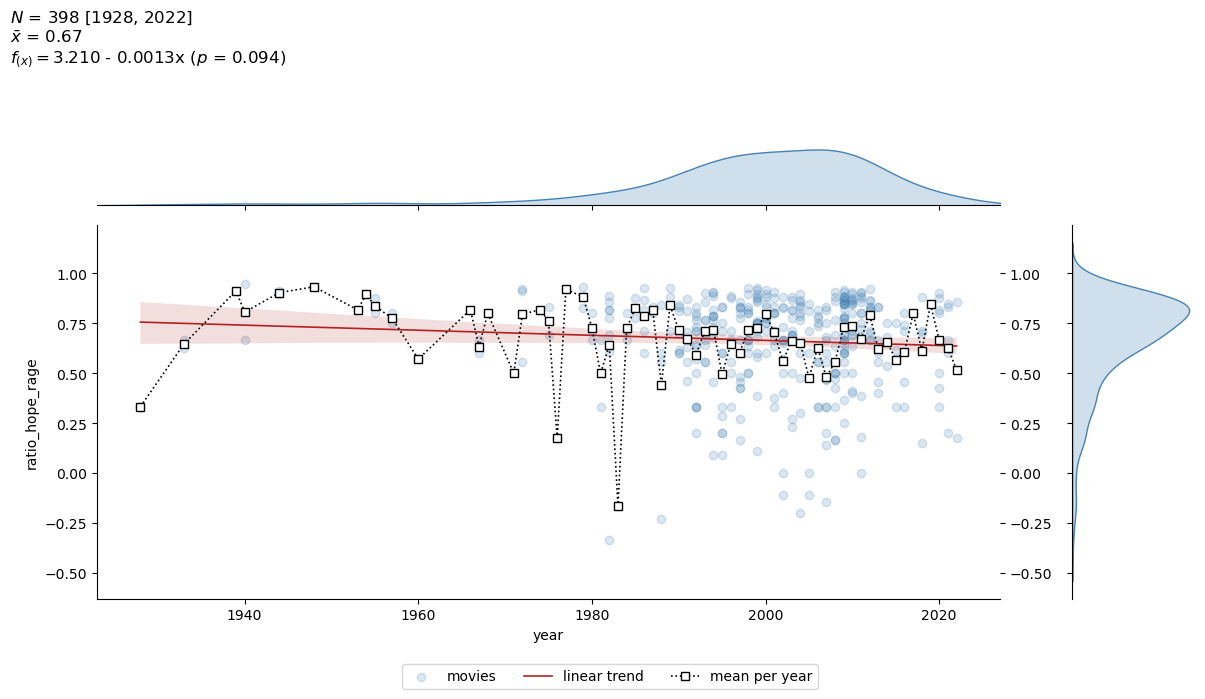

In [115]:
title = (
    f"$N$ = {len(df_clean)} [{min(df_clean.year)}, {max(df_clean.year)}]"
    + "\n"
    + r"$\bar{x}$ = "
    + f"{df_clean.ratio_hope_rage.mean():.2f}"
    + "\n"
    + r"$f_{(x)} = $"
    + f"{reg.intercept:.3f} {'+' if reg.slope > 0 else '-'} {abs(reg.slope):.2g}x"
    + " ($p$ = "
    + f"{reg.pvalue:.2g})"
)


g = sns.JointGrid(
    x=df_clean.year,
    y=df_clean.ratio_hope_rage,
    xlim=(-5 + min(df_clean.year), 5 + max(df_clean.year)),
)

regplot = g.plot_joint(
    sns.regplot,
    scatter_kws=dict(alpha=0.2, color="steelblue"),
    line_kws=dict(color="firebrick", lw=1.2, label="linear trend", linestyle="-"),
    label="movies",
    #lowess=True
)

g.plot_marginals(sns.kdeplot, fill=True, color="steelblue")
# g.ax_marg_y.set_visible(False)

g.fig.figure.set_figheight(6)
g.fig.figure.set_figwidth(12)


lplot = sns.lineplot(
    df_clean.groupby("year")["ratio_hope_rage"].mean(),
    lw=1.2,
    linestyle=":",
    marker="s",
    markersize=6,
    markeredgecolor="black",
    color="black",
    markeredgewidth=1,
    markerfacecolor="white",
    ax=g.ax_joint,
    label="mean per year",
    legend=False,
)
g.ax_joint.tick_params(right=True, labelright=True, grid_color="black")
g.fig.legend(loc="upper center", bbox_to_anchor=(0.5, 0), ncol=3)
g.fig.suptitle(
    title,
    x=0,
    fontsize=12,
    verticalalignment="bottom",
    horizontalalignment="left",
)
g.fig.tight_layout()

#### Distributions both ratios

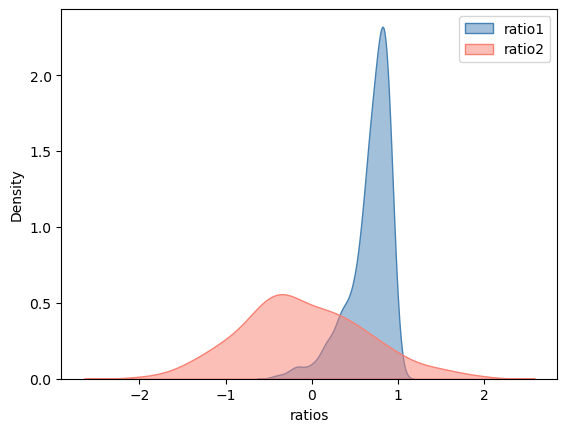

In [185]:
sns.kdeplot(
    df["ratio_hope_rage_out"], color="steelblue", alpha=0.5, label="ratio1", fill=True
)
sns.kdeplot(
    df["ratio_hope_rage2_out"], color="salmon", alpha=0.5, label="ratio2", fill=True
)
plt.xlabel("ratios")
plt.legend()

#### LOESS Regression both ratios

Output Summary
--------------
Number of Observations         : 398
Fit flag                       : 1
Equivalent Number of Parameters: 5.5
Residual Standard Error        : 0.2311 

Output Summary
--------------
Number of Observations         : 398
Fit flag                       : 1
Equivalent Number of Parameters: 5.5
Residual Standard Error        : 0.7019


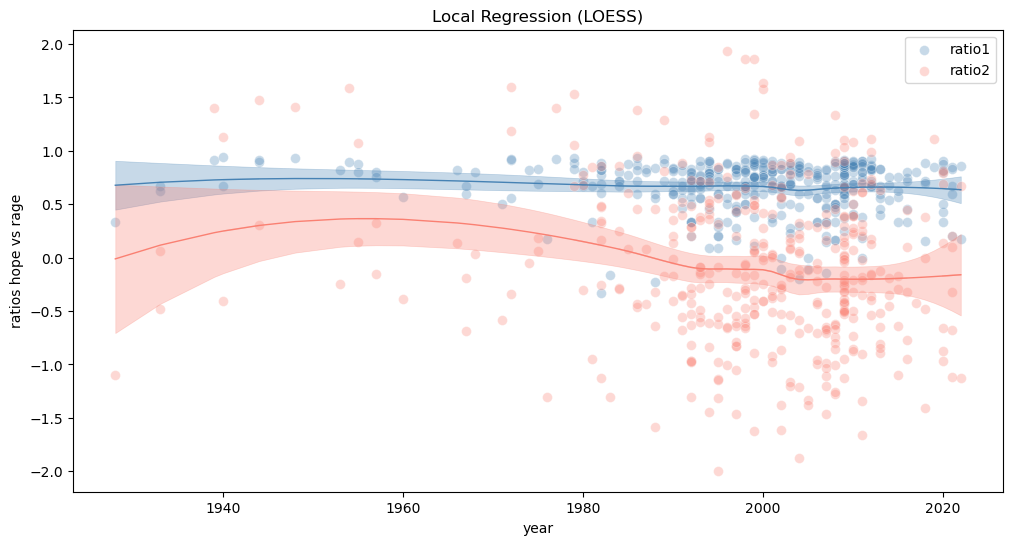

In [183]:
#!pip install scikit-misc

from skmisc.loess import loess, loess_confidence_intervals

fig, ax = plt.subplots(figsize=(12, 6))


def loess_plot(df, x_var, y_var, ax, color, label):

    loess_model = loess(df_clean[x_var], df_clean[y_var])
    # Unweighted fit (=default; all the weights are 1).
    y_fit = loess_model.outputs.fitted_values
    y_fit_lower_ci = loess_confidence_intervals(
        loess_model.predict(df_clean[x_var], stderror=True), 0.05
    ).lower

    y_fit_upper_ci = loess_confidence_intervals(
        loess_model.predict(df_clean[x_var], stderror=True), 0.05
    ).upper

    df_clean["loess_fitted_values"] = loess_model.outputs.fitted_values

    sns.lineplot(
        data=df_clean,
        x=x_var,
        y="loess_fitted_values",
        ax=ax,
        color=color,
        linewidth=1,
    )

    sns.scatterplot(
        data=df_clean,
        x=x_var,
        y=y_var,
        ax=ax,
        alpha=0.3,
        s=50,
        color=color,
        label=label,
    )

    ci_band = pd.DataFrame(columns=["x", "y_upper", "y_lower"])

    ci_band["x"] = df_clean[x_var]
    ci_band["y_upper"] = y_fit_upper_ci
    ci_band["y_lower"] = y_fit_lower_ci
    ci_band = ci_band.sort_values("x")
    ax.fill_between(
        x=ci_band["x"],
        y1=ci_band["y_upper"],
        y2=ci_band["y_lower"],
        alpha=0.3,
        linewidth=0.5,
        color=color,
    )
    ax.set_title("Local Regression (LOESS)")
    ax.set_ylabel(y_var)
    plt.legend()

    return loess_model.output_summary()


summary1 = loess_plot(
    df_clean, "year", "ratio_hope_rage_out", ax, color="steelblue", label="ratio1"
)
summary2 = loess_plot(
    df_clean, "year", "ratio_hope_rage2_out", ax, color="salmon", label="ratio2"
)

print(summary1, "\n")
print(summary2)

plt.ylabel("ratios hope vs rage")
plt.savefig("fig_ratio_loess.png", dpi=300)

<div class="alert alert-warning">What value does this comparison of two such different kind of "ratios" give us?</div>